## Deep Learning sobre dados meteorológicos tabulares: Versão Final

### Projeto elaborado na disciplina MO434 - Deep Learning (2s2020)

Grupo: Raysa Benatti/176483, Mauricio Araujo/184477, Matheus Ataide/147375

Para rodar o código, é necessário fazer upload do arquivo ``esalq.XLS``.

O arquivo pode ser acessado [aqui](http://www.leb.esalq.usp.br/leb/postocon.html) ("Valores Absolutos"), devendo ser renomeado para ``esalq.XLS``. 

O relatório que detalha o experimento pode ser lido [aqui](https://github.com/ra-ysa/deep_learning/blob/main/vers%C3%A3o%20final/final.pdf).

### Baseline vs. Versão Final

O baseline completo pode ser acessado [aqui](https://github.com/ra-ysa/deep_learning/blob/main/proposta%20e%20baseline/baseline.ipynb) e compreende:
- Leitura e pré-processamento dos dados;
- Separação dos dados em conjuntos de treino, validação e teste;
- Implementação de dois modelos LSTM vanilla univariados, com 15 e 50 unidades;
- Plotagem de gráficos de loss (MSE) e previsões.

Neste documento, repetimos as etapas essenciais do baseline, excluindo o modelo LSTM de 50 unidades, e acrescentamos, para a versão final:

- Cálculo de nova métrica numérica de avaliação (erro médio absoluto);
- Cálculo do tempo de execução;
- Testes com janelas de diferentes tamanhos;
- Redução para 100 épocas;
- Implementação de um modelo LSTM bidirecional;
- Implementação de um modelo baseado em Transformer. 

### Leitura e pré-processamento

In [1]:
import pandas as pd 
import numpy as np
from numpy import array
from matplotlib import pyplot as plt
import matplotlib as mpl
import time
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
def load_data():
    #Leitura e Preprocessamento
    esalq = pd.read_excel("esalq.XLS", skiprows=19)
    #extraimos so as 3 primeiras colunas, que nos interessam: ano, tmin e tmax
    esalq = esalq.iloc[:,[0,1,2]]
    #renomeamos colunas
    esalq.rename(columns={esalq.columns[0]: "ano", esalq.columns[1]: "tmax", esalq.columns[2]: "tmin"}, inplace = True)

    #preprocessamento: extrair somente dados brutos de tmax e tmin mes a mes, pra todos os anos
    #excluir linhas de gap e reorganizar as linhas
    #para tanto, extraimos os dados mes a mes e os concatenamos depois

    #no dataset original, a organizacao seguida eh:

    # repete 12x (1x para cada mes)
    #   HEADER
    #   linha gap
    #   linha gap
    #   1917
    #   1918
    #   ...
    #   2019
    #   2020 (exceto para dezembro)
    #   14 linhas gap

    months = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
    init = 2
    end = 106

    data = pd.DataFrame()

    for month in months:
        esalq_month = esalq.iloc[init:end]
        esalq_month = esalq_month.copy()
        init+= 121
        if month != "nov": #dezembro nao tem registros em 2020
            end+= 121
        else:
            end+= 120

        #renomeamos cada "ano" para "ano-mes"
        for index, row in esalq_month.iterrows():
            esalq_month.loc[index, "ano"] = str(row[0])+"-"+month
    
        #concatenar
        data = data.append(esalq_month, ignore_index=True)

    #conversao de tipos
    data = data.astype({"tmax": float, "tmin": float}, errors="ignore")

    #reordenando linhas para ficarem em ordem cronologica 
    tags = []
    start=0
    step=12
    stop=(104*step)
    for j in range(12):
        for i in range(start, stop, step):
            tags.append(i)
        start=start+1
        stop=stop+1
    tags.pop() #deleta ultimo indice, ja que pra 2020 ha 11 elementos e nao 12

    data["tag"] = tags
    data.sort_values(by="tag", axis=0, inplace=True, ignore_index=True)
    data.drop(columns=["tag"], inplace=True)
    return data
data = load_data()
data.head()

,ano,tmax,tmin
0,1917-jan,30.8,15.0
1,1917-fev,32.2,15.4
2,1917-mar,33.5,13.6
3,1917-abr,30.0,7.8
4,1917-mai,29.0,2.2


### Split

In [2]:
#dividindo os dados em treino, validacao e teste na proporcao 70:20:10

column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

num_features = data.shape[1]
print(f'{len(train_df)} dados para treino')
print(f'{len(val_df)} dados para validação')
print(f'{len(test_df)} dados para teste')

872 dados para treino
250 dados para validação
125 dados para teste


### LSTM vanilla

In [12]:
# GERADOR DE JANELAS
# univariate data preparation
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X = []
    y = []
    #, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
raw_seq = train_df["tmax"]
# choose a number of time steps
n_steps = 20
# split into samples
X_train, y_train = split_sequence(train_df["tmax"].values, n_steps)
X_val, y_val = split_sequence(val_df["tmax"].values, n_steps)
X_test, y_test = split_sequence(test_df["tmax"].values, n_steps)

# summarize the data
print(f'Windows de tamanho {X_train.shape[1]} e {X_train.shape[0]} dados gerados para treino')
print(f'Windows de tamanho {X_val.shape[1]} e {X_val.shape[0]} dados gerados para validação')
print(f'Windows de tamanho {X_test.shape[1]} e {X_test.shape[0]} dados gerados para teste')

Windows de tamanho 20 e 852 dados gerados para treino
Windows de tamanho 20 e 230 dados gerados para validação
Windows de tamanho 20 e 105 dados gerados para teste


In [13]:
#removemos linhas que possuem valores NaN
def remove_nan(X, Y):
    ok = []
    for i in range(len(X)):
        if np.isnan(Y[i]) or np.isnan(np.sum(X[i])):
            ok += [False]
        else:
            ok += [True]
    ok = np.array(ok)
    return X[ok], Y[ok]

#demonstracao de janelas
X, y = remove_nan(X_train, y_train)
for i in range(len(X)):
    print(X[i], y[i])

[30.8 32.2 33.5 30.  29.  27.2 28.8 31.  34.5 34.2 36.6 36.  34.4 33.2
 32.6 32.  30.  30.  29.  31.5] 34.0
[32.2 33.5 30.  29.  27.2 28.8 31.  34.5 34.2 36.6 36.  34.4 33.2 32.6
 32.  30.  30.  29.  31.5 34. ] 33.1
[33.5 30.  29.  27.2 28.8 31.  34.5 34.2 36.6 36.  34.4 33.2 32.6 32.
 30.  30.  29.  31.5 34.  33.1] 35.0
[30.  29.  27.2 28.8 31.  34.5 34.2 36.6 36.  34.4 33.2 32.6 32.  30.
 30.  29.  31.5 34.  33.1 35. ] 33.2
[29.  27.2 28.8 31.  34.5 34.2 36.6 36.  34.4 33.2 32.6 32.  30.  30.
 29.  31.5 34.  33.1 35.  33.2] 33.5
[27.2 28.8 31.  34.5 34.2 36.6 36.  34.4 33.2 32.6 32.  30.  30.  29.
 31.5 34.  33.1 35.  33.2 33.5] 35.4
[28.8 31.  34.5 34.2 36.6 36.  34.4 33.2 32.6 32.  30.  30.  29.  31.5
 34.  33.1 35.  33.2 33.5 35.4] 33.8
[31.  34.5 34.2 36.6 36.  34.4 33.2 32.6 32.  30.  30.  29.  31.5 34.
 33.1 35.  33.2 33.5 35.4 33.8] 32.1
[34.5 34.2 36.6 36.  34.4 33.2 32.6 32.  30.  30.  29.  31.5 34.  33.1
 35.  33.2 33.5 35.4 33.8 32.1] 29.8
[34.2 36.6 36.  34.4 33.2 32.6 32

 32.8 29.4 28.4 27.4 31.  31.7] 31.4
[35.4 33.  31.5 28.2 26.  27.  30.4 33.5 34.3 32.8 35.8 33.  31.  32.8
 29.4 28.4 27.4 31.  31.7 31.4] 35.8
[33.  31.5 28.2 26.  27.  30.4 33.5 34.3 32.8 35.8 33.  31.  32.8 29.4
 28.4 27.4 31.  31.7 31.4 35.8] 32.2
[31.5 28.2 26.  27.  30.4 33.5 34.3 32.8 35.8 33.  31.  32.8 29.4 28.4
 27.4 31.  31.7 31.4 35.8 32.2] 34.8
[28.2 26.  27.  30.4 33.5 34.3 32.8 35.8 33.  31.  32.8 29.4 28.4 27.4
 31.  31.7 31.4 35.8 32.2 34.8] 35.7
[26.  27.  30.4 33.5 34.3 32.8 35.8 33.  31.  32.8 29.4 28.4 27.4 31.
 31.7 31.4 35.8 32.2 34.8 35.7] 34.0
[27.  30.4 33.5 34.3 32.8 35.8 33.  31.  32.8 29.4 28.4 27.4 31.  31.7
 31.4 35.8 32.2 34.8 35.7 34. ] 31.9
[30.4 33.5 34.3 32.8 35.8 33.  31.  32.8 29.4 28.4 27.4 31.  31.7 31.4
 35.8 32.2 34.8 35.7 34.  31.9] 30.9
[33.5 34.3 32.8 35.8 33.  31.  32.8 29.4 28.4 27.4 31.  31.7 31.4 35.8
 32.2 34.8 35.7 34.  31.9 30.9] 28.8
[34.3 32.8 35.8 33.  31.  32.8 29.4 28.4 27.4 31.  31.7 31.4 35.8 32.2
 34.8 35.7 34.  31.9 30.9 28.

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense

#vanilla lstm
n_features = 1 # 1 variavel
# define model
model = Sequential()
model.add(LSTM(15, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
# fit model
epochs=100
start_time = time.time()
history=model.fit(X, y, epochs=epochs, validation_data=(X_val.reshape(X_val.shape[0], X_val.shape[1], n_features), y_val),verbose=1)
end_time = time.time()
total_time = end_time - start_time

print("Tempo total de execução: {}".format(total_time))

Epoch 1/100
24/24 [==============================] - 2s 30ms/step - loss: 65.0689 - val_loss: 27.6760
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 22.6117 - val_loss: 8.8999
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 11.1119 - val_loss: 9.6248
Epoch 4/100
24/24 [==============================] - 0s 10ms/step - loss: 8.4351 - val_loss: 8.0450
Epoch 5/100
24/24 [==============================] - 0s 10ms/step - loss: 7.9691 - val_loss: 7.6247
Epoch 6/100
24/24 [==============================] - 0s 10ms/step - loss: 6.9081 - val_loss: 10.0212
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 7.3247 - val_loss: 10.4729
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 7.2421 - val_loss: 8.7727
Epoch 9/100
24/24 [==============================] - 0s 10ms/step - loss: 6.8975 - val_loss: 8.9077
Epoch 10/100
24/24 [==============================] - 0s 15ms/step - loss: 7.5040 - val_loss: 

In [6]:
def plot_history(history, data_time=200, gen_data_time=False,no_key=["title"],figure_size=(10,8)):
    mpl.rcParams['figure.figsize'] = figure_size
    if(gen_data_time):
        data_time = np.arange(data_time) 
    fig, ax = plt.subplots()
    for key in history.keys():
        if(not key in no_key):
            x, y = data_time, history[key]
            ax.plot(x, y,  label=key)
    legend = ax.legend(loc='best')
    ax.set_title(history.get("title"))
    plt.show()

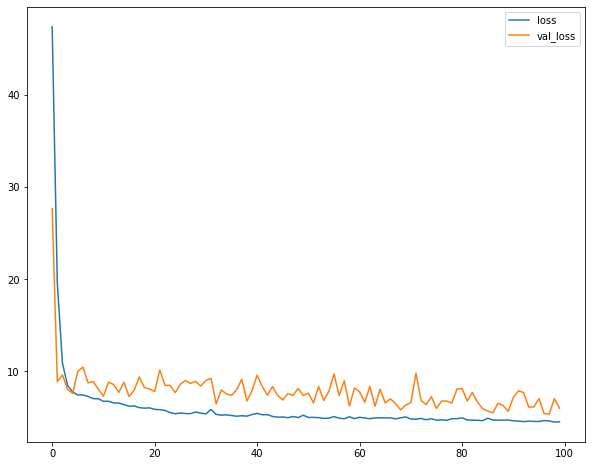

In [ ]:
# Plotagem de Loss

plot_history(history= history.history, data_time=epochs, gen_data_time=True)

In [ ]:
# Predição e Plotagem para conjunto de validação

history_val ={"predict":[],"real": y_val,"title":"Conjunto de validação"}
for i in range(len(X_val)):
    x_input=X_val[i].reshape((1, n_steps, n_features))
    history_val["predict"].append(model.predict(x_input)[0][0])

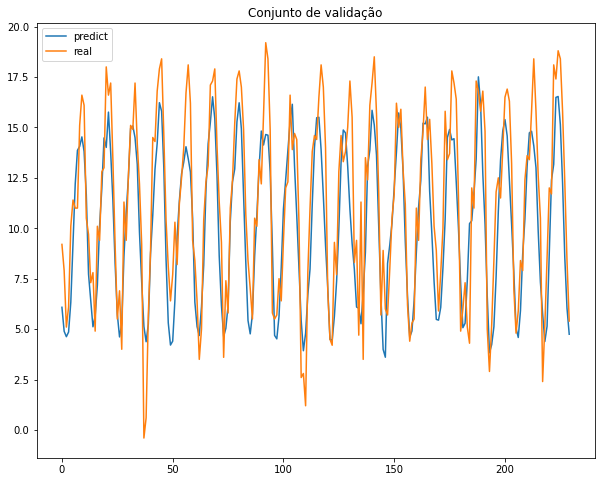

In [ ]:
plot_history(history= history_val, data_time=len(history_val["predict"]), gen_data_time=True)

In [7]:
# calculo de erros

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
print(mean_absolute_error(history_val["real"], history_val["predict"]))
print(mean_squared_error(history_val["real"], history_val["predict"]))

2.086973722136539
6.651216545423764


### LSTM bidirecional

In [15]:
from keras.layers import Bidirectional

#define model
model = Sequential()
model.add(Bidirectional(LSTM(15, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [16]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
# fit model
epochs=100
start_time = time.time()
history=model.fit(X, y, epochs=epochs, validation_data=(X_val.reshape(X_val.shape[0], X_val.shape[1], n_features), y_val),verbose=1)
end_time = time.time()
total_time = end_time - start_time

print("Tempo total de execução: {}".format(total_time))

Train on 767 samples, validate on 230 samples
Epoch 1/100
767/767 [==============================] - 2s 2ms/step - loss: 499.3406 - val_loss: 546.8029
Epoch 2/100
767/767 [==============================] - 0s 454us/step - loss: 2192.6312 - val_loss: 1623.1388
Epoch 3/100
767/767 [==============================] - 0s 443us/step - loss: 316.8042 - val_loss: 35.0662
Epoch 4/100
767/767 [==============================] - 0s 444us/step - loss: 20.3617 - val_loss: 15.8313
Epoch 5/100
767/767 [==============================] - 0s 458us/step - loss: 16.4281 - val_loss: 14.6320
Epoch 6/100
767/767 [==============================] - 0s 451us/step - loss: 15.2688 - val_loss: 14.1776
Epoch 7/100
767/767 [==============================] - 0s 453us/step - loss: 15.0370 - val_loss: 14.2434
Epoch 8/100
767/767 [==============================] - 0s 440us/step - loss: 14.3592 - val_loss: 13.7129
Epoch 9/100
767/767 [==============================] - 0s 449us/step - loss: 13.8414 - val_loss: 12.9616
Epoc

Epoch 79/100
767/767 [==============================] - 0s 438us/step - loss: 6.2957 - val_loss: 6.8581
Epoch 80/100
767/767 [==============================] - 0s 425us/step - loss: 6.3431 - val_loss: 6.4678
Epoch 81/100
767/767 [==============================] - 0s 425us/step - loss: 6.1477 - val_loss: 6.3573
Epoch 82/100
767/767 [==============================] - 0s 445us/step - loss: 6.1528 - val_loss: 6.4187
Epoch 83/100
767/767 [==============================] - 0s 438us/step - loss: 6.1900 - val_loss: 6.6204
Epoch 84/100
767/767 [==============================] - 0s 416us/step - loss: 6.5342 - val_loss: 6.8710
Epoch 85/100
767/767 [==============================] - 0s 419us/step - loss: 6.3546 - val_loss: 6.7465
Epoch 86/100
767/767 [==============================] - 0s 417us/step - loss: 6.1194 - val_loss: 6.3525
Epoch 87/100
767/767 [==============================] - 0s 423us/step - loss: 6.1200 - val_loss: 6.3343
Epoch 88/100
767/767 [==============================] - 0s 437us

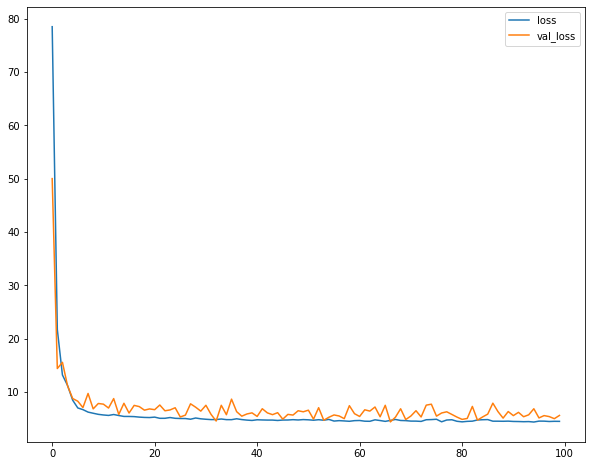

In [ ]:
# Plotagem de Loss

plot_history(history= history.history, data_time=epochs, gen_data_time=True)

In [ ]:
# Predição e Plotagem para conjunto de validação

history_val ={"predict":[],"real": y_val,"title":"Conjunto de validação"}
for i in range(len(X_val)):
    x_input=X_val[i].reshape((1, n_steps, n_features))
    history_val["predict"].append(model.predict(x_input)[0][0])

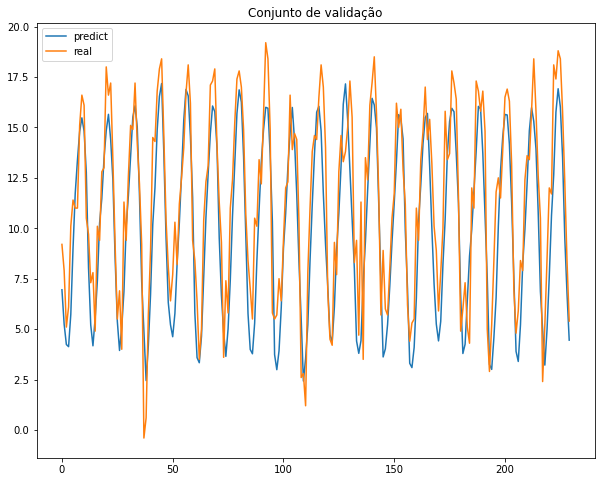

In [ ]:
plot_history(history= history_val, data_time=len(history_val["predict"]), gen_data_time=True)

In [ ]:
print(mean_absolute_error(history_val["real"], history_val["predict"]))
print(mean_squared_error(history_val["real"], history_val["predict"]))

1.6596687909831174
4.4331069816089315


### Transformer

In [5]:
#Bibliotecas
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from tensorflow.python.framework import ops
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
sns.set()
#tf.compat.v1.random.set_random_seed(1234)

Instructions for updating:
non-resource variables are not supported in the long term


<h4>Load and Split data</h4>

In [6]:
#Load data
df=load_data().dropna(how='any')
#Split
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]

#Apenas a feature max
df_train_max = df_train.iloc[:, 1:2].astype('float32')
df_val_max = df_val.iloc[:, 1:2].astype('float32')
df_test_max = df_test.iloc[:, 1:2].astype('float32')

#Apenas a feature min
df_train_min = df_train.iloc[:, 2:].astype('float32')
df_val_min = df_val.iloc[:, 2:].astype('float32')
df_test_min = df_test.iloc[:, 2:].astype('float32')

<h4>Normalização</h4>

In [7]:
#Normalização
scaler_max = MinMaxScaler().fit(df_train_max) 
scaler_min = MinMaxScaler().fit(df_train_min.values) 

<h4>Criamos abaixo a arquitetura da rede</h4>

In [8]:
def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))

    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    
    outputs = gamma * normalized + beta
    return outputs
    
def multihead_attn(queries, keys, q_masks, k_masks, future_binding, num_units, num_heads): 
    T_q = tf.shape(queries)[1]                                      
    T_k = tf.shape(keys)[1]                  

    Q = tf.layers.dense(queries, num_units, name='Q')                              
    K_V = tf.layers.dense(keys, 2*num_units, name='K_V')    
    K, V = tf.split(K_V, 2, -1)        

    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)                         
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)                    
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)                      

    align = tf.matmul(Q_, tf.transpose(K_, [0,2,1]))                      
    align = align / np.sqrt(K_.get_shape().as_list()[-1])                 

    paddings = tf.fill(tf.shape(align), float('-inf'))                   

    key_masks = k_masks                                                 
    key_masks = tf.tile(key_masks, [num_heads, 1])                       
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1])            
    align = tf.where(tf.equal(key_masks, 0), paddings, align)       

    if future_binding:
        lower_tri = tf.ones([T_q, T_k])                                          
        lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()  
        masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0], 1, 1]) 
        align = tf.where(tf.equal(masks, 0), paddings, align)                      
    
    align = tf.nn.softmax(align)                                            
    query_masks = tf.to_float(q_masks)                                             
    query_masks = tf.tile(query_masks, [num_heads, 1])                             
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])            
    align *= query_masks
    
    outputs = tf.matmul(align, V_)                                                 
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)             
    outputs += queries                                                             
    outputs = layer_norm(outputs)                                                 
    return outputs


def pointwise_feedforward(inputs, hidden_units, activation=None):
    outputs = tf.layers.dense(inputs, 4*hidden_units, activation=activation)
    outputs = tf.layers.dense(outputs, hidden_units, activation=None)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


def learned_position_encoding(inputs, mask, embed_dim):
    T = tf.shape(inputs)[1]
    outputs = tf.range(tf.shape(inputs)[1])                # (T_q)
    outputs = tf.expand_dims(outputs, 0)                   # (1, T_q)
    outputs = tf.tile(outputs, [tf.shape(inputs)[0], 1])   # (N, T_q)
    outputs = embed_seq(outputs, T, embed_dim, zero_pad=False, scale=False)
    return tf.expand_dims(tf.to_float(mask), -1) * outputs


def sinusoidal_position_encoding(inputs, mask, repr_dim):
    T = tf.shape(inputs)[1]
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1]) * tf.expand_dims(tf.to_float(mask), -1)

def label_smoothing(inputs, epsilon=0.1):
    C = inputs.get_shape().as_list()[-1]
    return ((1 - epsilon) * inputs) + (epsilon / C)

class Attention:
    def __init__(self, size_layer, embedded_size, learning_rate, size, output_size,
                 num_blocks = 2,
                 num_heads = 8,
                 min_freq = 50):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        
        #Posicional encoder
        encoder_embedded = tf.layers.dense(self.X, embedded_size)
        encoder_embedded = tf.nn.dropout(encoder_embedded, keep_prob = 0.8)
        x_mean = tf.reduce_mean(self.X, axis = 2)
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_position_encoding(self.X, en_masks, embedded_size)
        
        for i in range(num_blocks):
            with tf.variable_scope('encoder_self_attn_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = multihead_attn(queries = encoder_embedded,
                                             keys = encoder_embedded,
                                             q_masks = en_masks,
                                             k_masks = en_masks,
                                             future_binding = False,
                                             num_units = size_layer,
                                             num_heads = num_heads)

            with tf.variable_scope('encoder_feedforward_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = pointwise_feedforward(encoder_embedded,
                                                    embedded_size,
                                                    activation = tf.nn.relu)
                
        self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

<h4>Parâmetros da rede</h4>

In [20]:
num_layers = 1
size_layer = 128
timestamp = 8
epoch = 100
num_blocks = 2
dropout_rate = 0.8
learning_rate = 0.001

<h4>Run</h4>

In [10]:
def run_model(df_train,maxmim):
    df_train = pd.DataFrame(maxmim.transform(df_train))

    ops.reset_default_graph()
    modelnn = Attention(size_layer, size_layer, learning_rate, df_train.shape[1], df_train.shape[1],num_blocks)
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    pbar = tqdm(range(epoch), desc = 'train loop')

    for i in pbar:
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
              df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
              [modelnn.logits, modelnn.optimizer, modelnn.cost],
              feed_dict = {
                  modelnn.X: batch_x,
                  modelnn.Y: batch_y
              },
          ) 
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    return {'model':modelnn, 'run':sess}  

In [22]:
#Model 1
timestamp = 3
epoch = 100
start_time = time.time()

model_min_3=run_model(df_train_min, scaler_min)
model_max_3=run_model(df_train_max, scaler_max)

end_time = time.time()
total_time = end_time - start_time
print(f'Time Total para cada modelo : {total_time/2}')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '

train loop: 100%|██████████| 100/100 [02:49<00:00,  1.70s/it, acc=96, cost=0.00503]
/usr/

Time Total para cada modelo : 171.38076043128967


In [23]:
#Model 2
timestamp = 10
epoch = 100
start_time = time.time()

model_min_10=run_model(df_train_min, scaler_min)
model_max_10=run_model(df_train_max, scaler_max)

end_time = time.time()
total_time = end_time - start_time
print(f'Time Total para cada modelo : {total_time/2}')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '

train loop: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s, acc=95.8, cost=0.00441]
/us

Time Total para cada modelo : 65.09118187427521


In [29]:
#Model 3
timestamp = 20
epoch = 100
start_time = time.time()

model_min_20=run_model(df_train_min, scaler_min)
model_max_20=run_model(df_train_max, scaler_max)

end_time = time.time()
total_time = end_time - start_time
print(f'\n Time Total para cada modelo : {total_time/2}')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '

train loop: 100%|██████████| 100/100 [00:36<00:00,  2.74it/s, acc=94.1, cost=0.0081]
/usr


 Time Total para cada modelo : 38.278342723846436


<h4>Predição validação</h4>

In [12]:
def predict( modelnn, df ,minmax, run ):
    X_val, y_val = split_sequence(df.values, n_steps=timestamp)
    X_val = X_val[:,:,0]
    O=minmax.transform(X_val)
    output=[]
    for _input in O:
        out_logits = run.run(
          modelnn.logits,
          feed_dict = {
              modelnn.X: np.expand_dims(_input.reshape(-1,1), axis = 0)
          },
      )
        output.append(out_logits[-1])
    output=np.array(output)
    output = minmax.inverse_transform(output)
    output = anchor(output[:, 0], 0.3)
    return {'real':y_val,'predict':output}

In [30]:
#Predict pra cada modelo
predict_max_3=predict(modelnn=model_max_3['model'], df=df_val_max, minmax=scaler_max, run = model_max_3['run'] )
predict_min_3=predict(modelnn=model_min_3['model'], df=df_val_min, minmax=scaler_min, run = model_min_3['run'] )

predict_max_10=predict(modelnn=model_max_10['model'], df=df_val_max, minmax=scaler_max, run = model_max_10['run'] )
predict_min_10=predict(modelnn=model_min_10['model'], df=df_val_min, minmax=scaler_min, run = model_min_10['run'] )

predict_max_20=predict(modelnn=model_max_20['model'], df=df_val_max, minmax=scaler_max, run = model_max_20['run'] )
predict_min_20=predict(modelnn=model_min_20['model'], df=df_val_min, minmax=scaler_min, run = model_min_20['run'] )

<h4>Model 1 (window=3)<h4/>

Predição Temperatura mínima


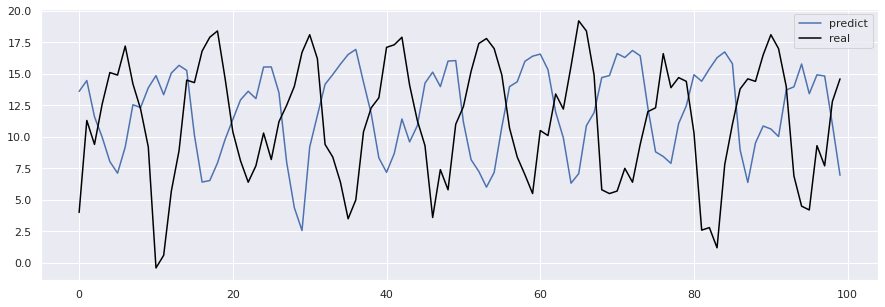

In [31]:
plt.figure(figsize = (15, 5))
plt.plot(predict_min_3['predict'][:100], label = 'predict')
plt.plot(predict_min_3['real'][:100], label = 'real', c = 'black')
plt.legend()
#plt.title('')
plt.show()

Erro:

In [32]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(predict_min_3['predict'], predict_min_3['real']))
print(mean_squared_error(predict_min_3['predict'], predict_min_3['real']))

6.596643288666368
55.98991929334094


Predição Temperatura máxima


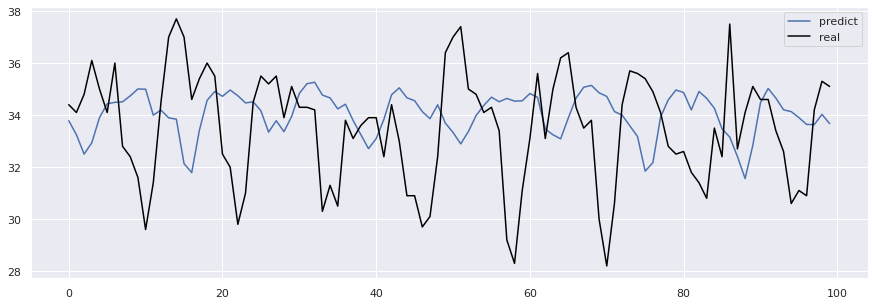

In [34]:
plt.figure(figsize = (15, 5))
plt.plot(predict_max_3['predict'][:100], label = 'predict')
plt.plot(predict_max_3['real'][:100], label = 'real', c = 'black')
plt.legend()
#plt.title('')
plt.show()

Erro:

In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(predict_max_3['predict'], predict_max_3['real']))
print(mean_squared_error(predict_max_3['predict'], predict_max_3['real']))

2.224546440052917
7.986682096739582


<h4>Model 2 (window=10)<h4/>

Predição Temperatura mínima


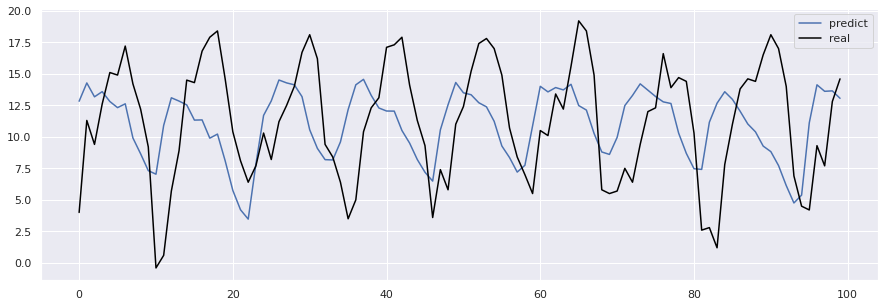

In [36]:
plt.figure(figsize = (15, 5))
plt.plot(predict_min_10['predict'][:100], label = 'predict')
plt.plot(predict_min_10['real'][:100], label = 'real', c = 'black')
plt.legend()
#plt.title('')
plt.show()

Erro:

In [37]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(predict_min_10['predict'], predict_min_10['real']))
print(mean_squared_error(predict_min_10['predict'], predict_min_10['real']))

4.122004140742802
23.196788121882246


Predição Temperatura máxima


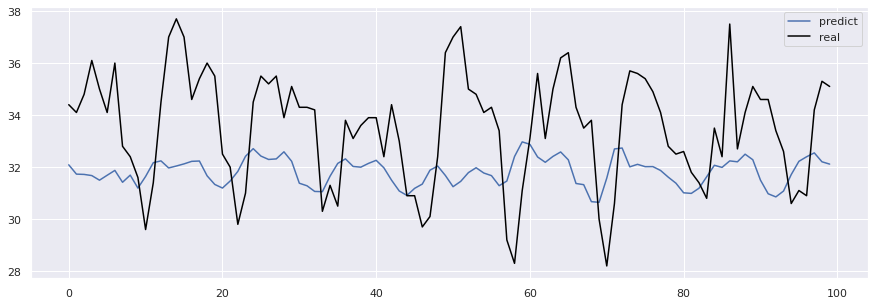

In [39]:
plt.figure(figsize = (15, 5))
plt.plot(predict_max_10['predict'][:100], label = 'predict')
plt.plot(predict_max_10['real'][:100], label = 'real', c = 'black')
plt.legend()
#plt.title('')
plt.show()

Erro:

In [40]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(predict_max_10['predict'], predict_max_10['real']))
print(mean_squared_error(predict_max_10['predict'], predict_max_10['real']))

2.496655777181133
8.571037158227222


<h4>Model 3 (window=20)<h4/>



Predição Temperatura mínima


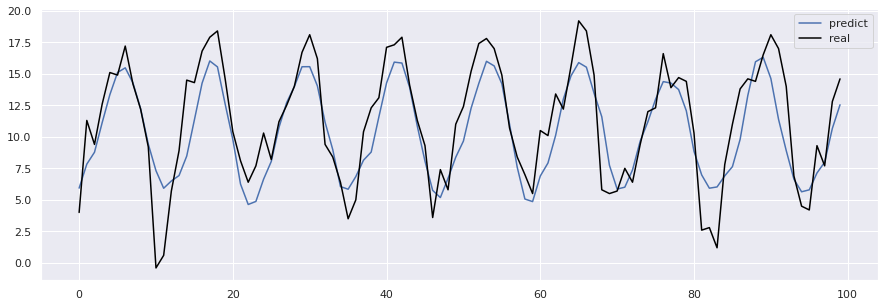

In [42]:
plt.figure(figsize = (15, 5))
plt.plot(predict_min_20['predict'][:100], label = 'predict')
plt.plot(predict_min_20['real'][:100], label = 'real', c = 'black')
plt.legend()
#plt.title('')
plt.show()

Erro:

In [43]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(predict_min_20['predict'], predict_min_20['real']))
print(mean_squared_error(predict_min_20['predict'], predict_min_20['real']))

2.0143146702792256
6.183116061941672


Predição Temperatura máxima


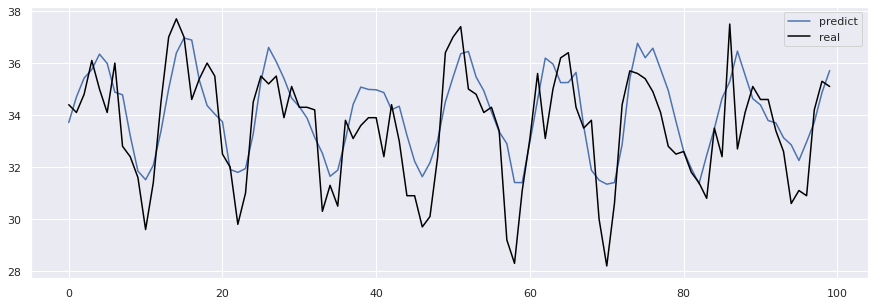

In [45]:
plt.figure(figsize = (15, 5))
plt.plot(predict_max_20['predict'][:100], label = 'predict')
plt.plot(predict_max_20['real'][:100], label = 'real', c = 'black')
plt.legend()
#plt.title('')
plt.show()

Erro:

In [46]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(predict_max_20['predict'], predict_max_20['real']))
print(mean_squared_error(predict_max_20['predict'], predict_max_20['real']))

1.3265508372117105
3.0846657750734976


### Teste Final

Execução sobre o conjunto de teste da LSTM Bidirecional, janelas de tamanho 20.

(O teste abaixo foi executado para temperaturas mínimas e, em seguida, para temperaturas máximas)

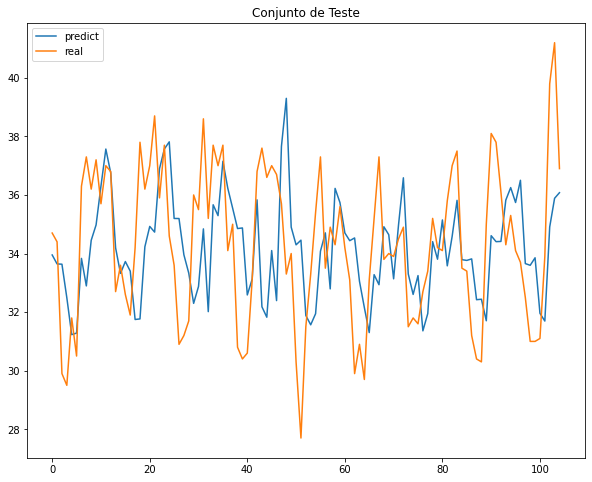

2.156641591389974
6.873768854170456


In [17]:
history_test ={"predict":[],"real": y_test,"title":"Conjunto de Teste"}

for i in range(len(X_test)):
    x_input=X_test[i].reshape((1, n_steps, n_features))
    history_test["predict"].append(model.predict(x_input)[0][0])
    
plot_history(history=history_test, data_time=len(history_test["predict"]), gen_data_time=True)

print(mean_absolute_error(history_test["real"], history_test["predict"]))
print(mean_squared_error(history_test["real"], history_test["predict"]))